In [4]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

import cv2
import random
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from tqdm import tqdm

Pertama pembersihan data

In [21]:
# ==== FUNGSI UNTUK MENGHAPUS GAMBAR NON-VALID ====
def remove_invalid_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is None:
                print(f"Menghapus file tidak valid: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f"Total file tidak valid yang dihapus: {removed}")



# Jalankan fungsi untuk menghapus gambar non-valid
remove_invalid_images("datasets/all_data")


Total file tidak valid yang dihapus: 0


Kedua adalah proses splitting dan pembersihan gambar dataset. Rasio splitnya adalah Train: 70%, Validation: 15%, Test: 15%

In [8]:

# Ambil semua path gambar dan label
def collect_images_and_labels(base_dir):
    images, labels = [], []
    for label, class_name in enumerate(["Cat", "Dog"]):
        class_dir = os.path.join(base_dir, class_name)
        for fname in os.listdir(class_dir):
            images.append(os.path.join(class_dir, fname))
            labels.append(label)
    return images, labels

all_images, all_labels = collect_images_and_labels("datasets/all_data")

# Split test set terlebih dahulu agar independen
X_trainval, X_test, y_trainval, y_test = train_test_split(
    all_images, all_labels, test_size=2500, stratify=all_labels, random_state=42
)

# Lalu split train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=5000, stratify=y_trainval, random_state=42
)

# Fungsi untuk copy gambar ke direktori target
def copy_files(image_paths, labels, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    count_cat = count_dog = 0

    for img_path, label in zip(image_paths, labels):
        class_name = "Cat" if label == 0 else "Dog"
        dest_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        shutil.copy(img_path, dest_class_dir)
        if label == 0:
            count_cat += 1
        else:
            count_dog += 1

    print(f"Total di {target_dir}: {count_cat} Cat, {count_dog} Dog, Total: {count_cat + count_dog}")

# Salin file ke folder datasets/
print("Menyalin file ke folder datasets/...")
copy_files(X_train, y_train, "datasets/train")
copy_files(X_val, y_val, "datasets/val")
copy_files(X_test, y_test, "datasets/test")

Menyalin file ke folder datasets/...
Total di datasets/train: 8725 Cat, 8721 Dog, Total: 17446
Total di datasets/val: 2501 Cat, 2499 Dog, Total: 5000
Total di datasets/test: 1250 Cat, 1250 Dog, Total: 2500


Membersihkan data gambar yang tidak valid

In [ ]:
# ===============================
#  Fungsi Pembersih Gambar Rusak
# ===============================
# def remove_invalid_images(directory):
#     removed = 0
#     for root, _, files in os.walk(directory):
#         for name in files:
#             file_path = os.path.join(root, name)
#             try:
#                 img = Image.open(file_path)
#                 img.verify()
#             except:
#                 os.remove(file_path)
#                 removed += 1
#                 print(f"Removed invalid image: {file_path}")
#     print(f"Total removed from {directory}: {removed}")


# # ===============================
# #  Pembersihan Gambar Rusak SETELAH Split
# # ===============================
# print("Membersihkan gambar rusak setelah proses split...")
# remove_invalid_images('datasets/train')
# remove_invalid_images('datasets/val')
# remove_invalid_images('datasets/test')

Membersihkan gambar rusak setelah proses split...


d:\PROJECT\SIB DBS FOUNDATION\submission klasifikasi gambar\catdogs1000\submissionFiqi\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed invalid image: datasets/train\Dogs\Thumbs.db
Total removed from datasets/train: 1
Removed invalid image: datasets/val\Cats\666.jpg
Removed invalid image: datasets/val\Cats\Thumbs.db
Removed invalid image: datasets/val\Dogs\11702.jpg
Total removed from datasets/val: 3
Removed invalid image: datasets/test\Cats\666.jpg
Removed invalid image: datasets/test\Cats\Thumbs.db
Removed invalid image: datasets/test\Dogs\11702.jpg
Removed invalid image: datasets/test\Dogs\Thumbs.db
Total removed from datasets/test: 4


In [9]:

# Validasi
print("=== Validation Set ===")
print("Val - Cats:", len(os.listdir("datasets/val/Cat")))
print("Val - Dogs:", len(os.listdir("datasets/val/Dog")))
print("Total Val:", len(os.listdir("datasets/val/Cat")) + len(os.listdir("datasets/val/Dog")))
print()

# Training
print("=== Training Set ===")
print("Train - Cats:", len(os.listdir("datasets/train/Cat")))
print("Train - Dogs:", len(os.listdir("datasets/train/Dog")))
print("Total Train:", len(os.listdir("datasets/train/Cat")) + len(os.listdir("datasets/train/Dog")))
print()

# Testing
print("=== Testing Set ===")
print("Test - Cats:", len(os.listdir("datasets/test/Cat")))
print("Test - Dogs:", len(os.listdir("datasets/test/Dog")))
print("Total Test:", len(os.listdir("datasets/test/Cat")) + len(os.listdir("datasets/test/Dog")))

=== Validation Set ===
Val - Cats: 2501
Val - Dogs: 2499
Total Val: 5000

=== Training Set ===
Train - Cats: 8725
Train - Dogs: 8721
Total Train: 17446

=== Testing Set ===
Test - Cats: 1250
Test - Dogs: 1250
Total Test: 2500


Lanjut ke proses pipeline data loading

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "datasets/train",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    "datasets/val",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    "datasets/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)

Found 17446 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Kemudian lanjut mendefinisikan arsitektur model CNN menggunakan Sequential dari Keras, untuk klasifikasi biner gambar grayscale berukuran 150x150

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

d:\PROJECT\SIB DBS FOUNDATION\submission klasifikasi gambar rev3\submissionFiqi\.env39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,727,169 (40.92 MB)

 Trainable params: 10,726,721 (40.92 MB)

 Non-trainable params: 448 (1.75 KB)

Menambahkan callback untuk mengoptimalkan proses pelatihan

In [13]:
class EarlyStoppingAtEpoch(Callback):
    def __init__(self, stop_epoch=20):
        super(EarlyStoppingAtEpoch, self).__init__()
        self.stop_epoch = stop_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.stop_epoch:
            print(f"\nStopping training at epoch {epoch + 1}")
            self.model.stop_training = True


callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStoppingAtEpoch(stop_epoch=30)
]

Lanjut menghitung class weights

In [14]:
cat_count = len(os.listdir('datasets/train/Cat'))
dog_count = len(os.listdir('datasets/train/Dog'))

total = cat_count + dog_count
weight_cat = (1 / cat_count) * total / 2.0
weight_dog = (1 / dog_count) * total / 2.0

class_weights = {0: weight_cat, 1: weight_dog}

Mulai training Model menggunakan 30 epoch (karena saya mengejar akurasi tinggi diatas 95%)

In [15]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    class_weight = class_weights,
    callbacks = callbacks
)

d:\PROJECT\SIB DBS FOUNDATION\submission klasifikasi gambar rev3\submissionFiqi\.env39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
328/546 ━━━━━━━━━━━━━━━━━━━━ 4:13 1s/step - accuracy: 0.5303 - loss: 2.7038

d:\PROJECT\SIB DBS FOUNDATION\submission klasifikasi gambar rev3\submissionFiqi\.env39\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5343 - loss: 2.1937
Epoch 1: val_loss improved from inf to 0.66410, saving model to best_model.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 714s 1s/step - accuracy: 0.5343 - loss: 2.1921 - val_accuracy: 0.6220 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 2/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6106 - loss: 0.6565
Epoch 2: val_loss did not improve from 0.66410
546/546 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.6106 - loss: 0.6564 - val_accuracy: 0.5732 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6969 - loss: 0.5890
Epoch 3: val_loss improved from 0.66410 to 0.54641, saving model to best_model.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.6969 - loss: 0.5890 - val_accuracy: 0.7128 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 4/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7605 - loss: 0.5116
Epoch 4: val_loss did not improve from 0.54641
546/546 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.7605 - loss: 0.5116 - val_accuracy: 0.6916 - val_loss: 0.5571 - learning_rate: 0.0010
Epoch 5/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.7984 - loss: 0.4515
Epoch 5: val_loss improved from 0.54641 to 0.49324, saving model to best_model.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 543s 994ms/step - accuracy: 0.7984 - loss: 0.4515 - val_accuracy: 0.7760 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 6/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.8366 - loss: 0.3792
Epoch 6: val_loss did not improve from 0.49324
546/546 ━━━━━━━━━━━━━━━━━━━━ 538s 986ms/step - accuracy: 0.8366 - loss: 0.3791 - val_accuracy: 0.7730 - val_loss: 0.5051 - learning_rate: 0.0010
Epoch 7/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8683 - loss: 0.3138
Epoch 7: val_loss improved from 0.49324 to 0.43736, saving model to best_model.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 534s 977ms/step - accuracy: 0.8683 - loss: 0.3138 - val_accuracy: 0.7920 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 8/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9057 - loss: 0.2314
Epoch 8: val_loss improved from 0.43736 to 0.39327, saving model to best_model.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 533s 975ms/step - accuracy: 0.9057 - loss: 0.2314 - val_accuracy: 0.8242 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 9/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.9366 - loss: 0.1695
Epoch 9: val_loss did not improve from 0.39327
546/546 ━━━━━━━━━━━━━━━━━━━━ 536s 981ms/step - accuracy: 0.9366 - loss: 0.1696 - val_accuracy: 0.7546 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 10/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9535 - loss: 0.1243
Epoch 10: val_loss did not improve from 0.39327

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
546/546 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.9535 - loss: 0.1243 - val_accuracy: 0.8662 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 11/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9751 - loss: 0.0757
Epoch 11: val_loss did not improve from 0.39327
546/546 ━━━━━━━━━━━━━━━━━━━━ 640s 1s/step - accuracy: 0.9751 - loss: 0.0757 - val_accur

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.8962 - loss: 0.7421
Test Accuracy: 0.9116


Plot Akurasi

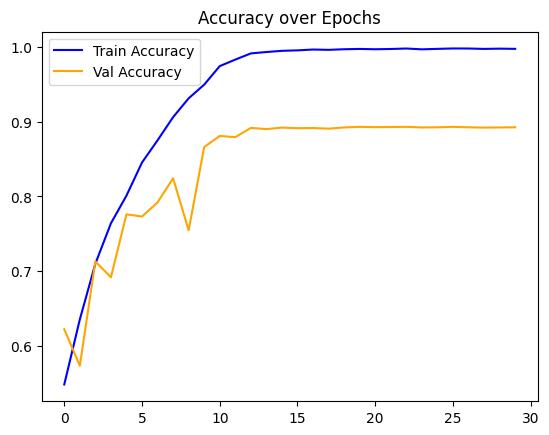

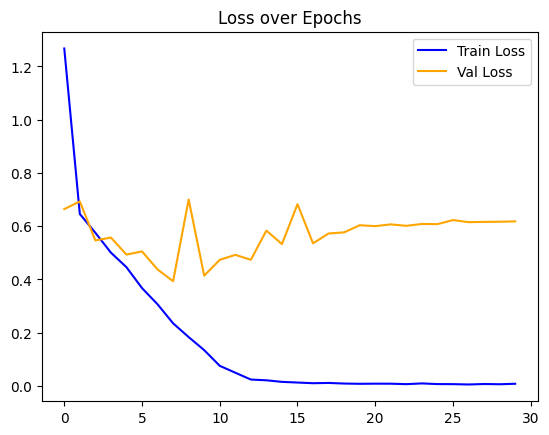

In [17]:

plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Hasil classification report

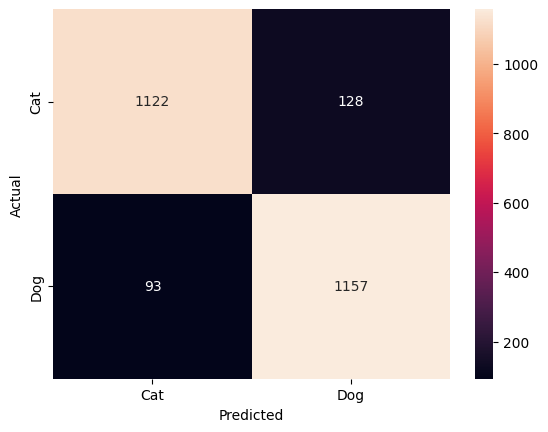

              precision    recall  f1-score   support

         Cat       0.92      0.90      0.91      1250
         Dog       0.90      0.93      0.91      1250

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500



In [18]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
preds_binary = (preds > 0.5).astype(int)

cm = confusion_matrix(test_generator.classes, preds_binary)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_generator.classes, preds_binary, target_names=['Cat','Dog']))

Dihasilkan recall dengan point 0.98

Dikarenakan di Komputer saya terjadi crash instalasi tensorflowjs yang tidak bisa saya perbaiki. Jadi saya memutuskan untuk menggunakan google collab sebagai konverter save_model ke tfjs

Maka model harus di save dulu ke saved_model

In [20]:
# Buat folder tujuan jika belum ada
os.makedirs("saved_model", exist_ok=True)

# Simpan model ke format SavedModel (standar TensorFlow)
model.export("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2454039679040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454039679392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454060974144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454060975200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454060899840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454060900016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454061044304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454061044128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454061026288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454047944768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2454061025760: TensorSpec(shape=(), dty